In [8]:
import numpy as np
import pylab as plt
import torch
from tqdm.auto import tqdm
import scipy.linalg
import pandas as pd
import torchvision.datasets as dst

from common import gsave, gload
from nde.common import joint_density
from nde.kernels import load_mnist_all, KernelPredictor, KernelType

def apply_noise(Y, confusion_matx):
    C = torch.Tensor(confusion_matx)  # C[i, j] = Pr[j --> i]
    Y_new = np.empty_like(Y)
    for i in range(len(Y)):
        y = Y[i]
        p = C[:, y]
        yNew = torch.distributions.categorical.Categorical(probs=p).sample()
        Y_new[i] = yNew
    return Y_new

In [2]:
X, Y = load_mnist_all()
ker = KernelPredictor(X, Y)

In [22]:
## SETUP. Superclass: Even/Odd

y = (Y % 2)
L = Y

ntr = 60000
I_tr = list(range(0, ntr))
I_te = list(range(60000, 70000))
ktype = KernelType.GAUSSIAN
sigma=0.15

Kte = ker.d_to_K(ker.D[I_te, :][:, I_tr], ktype, sigma)
Ktr = ker.d_to_K(ker.D[I_tr, :][:, I_tr], ktype, sigma)

# y_tr = y[I_tr]
y_te = y[I_te]
L_tr = L[I_tr]
L_te = L[I_te]

def train(y_tr, nc=2):
    Y = np.eye(nc)[y_tr]
    model = scipy.linalg.solve(Ktr, Y, sym_pos=True, check_finite=False)
    yhats = Kte.dot(model)
    preds = np.argmax(yhats, axis=1)
    return preds

In [13]:
## single test
C = np.eye(10) # C[i, j] = Pr[j --> i]
C[0, 0] = 0.7
C[1, 0] = 0.3

y_tr = apply_noise(L_tr, C) % 2

predsTe = train(y_tr, nc=2)

acc    = (predsTe == y_te).mean()
print(f'test acc: {acc}')

cm_tr = joint_density(y_tr, L_tr, nY=2, nL=10)
cm_te = joint_density(predsTe, L_te,nY=2, nL=10)

test acc: 0.957


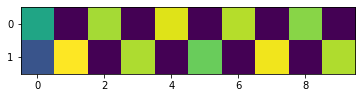

In [14]:
plt.imshow(cm_tr)

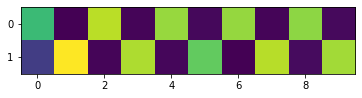

In [15]:
plt.imshow(cm_te)

In [23]:
## ARRAY of CMs

res = []

ps = np.linspace(0, 1, 11)
for p in ps:
    C = np.eye(10) # C[i, j] = Pr[j --> i]
    C[0, 0] = (1-p)
    C[1, 0] = p

    y_tr = apply_noise(L_tr, C) % 2
    predsTe = train(y_tr, nc=2)
    acc    = (predsTe == y_te).mean()
#     tr_acc = (predsTr == y_tr).mean()
#     print(f'p:{p}\t test acc: {acc} \t train acc: {tr_acc}')
    print(f'p:{p}\t test acc: {acc}')
    
    cm_tr = joint_density(y_tr, L_tr, nY=2, nL=10)
    cm_te = joint_density(predsTe, L_te,nY=2, nL=10)
    
    d = {
        'p' : p,
        'acc' : acc,
        'cm_tr' : cm_tr,
        'cm_te' : cm_te}
    
    res.append(d)
    
gsave(res, f'gs://ANONYMOUS/results/nde/kernels/conf_sup/mnist/EvenOdd_targ01')    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: LinAlgWarning: Ill-conditioned matrix (rcond=6.58983e-09): result may not be accurate.


p:0.0	 test acc: 0.9938
p:0.1	 test acc: 0.9921
p:0.2	 test acc: 0.9828
p:0.30000000000000004	 test acc: 0.9727
p:0.4	 test acc: 0.9602
p:0.5	 test acc: 0.9471
p:0.6000000000000001	 test acc: 0.9278
p:0.7000000000000001	 test acc: 0.9175
p:0.8	 test acc: 0.9026
p:0.9	 test acc: 0.8962
p:1.0	 test acc: 0.8947
